## A Demonstration of Estimating $\epsilon$-machines using <tt>CSSR</tt> and Analyzing Their Information-Theoretic Properties 

In [2]:
# This line just makes plots visible in-notebook, rather than opening stand-alone windows.

#%matplotlib nbagg

We begin by loading in the required Python packages. In addition to the necessary packages listed on the GitHub page for <tt>transCSSR</tt>, you will also need [graphviz](http://graphviz.readthedocs.io/en/stable/manual.html) to visualize the $\epsilon$-machines in-notebook, and [scikit-learn](http://scikit-learn.org/stable/) to compute the log-loss for selecting the appropriate lookback length.

In [3]:
from transCSSR import *
import matplotlib.pyplot as plt

import graphviz
from sklearn.metrics import log_loss

import itertools

### Estimating the $\epsilon$-Machine Using <tt>CSSR</tt>

Next, we load in the data files. <tt>transCSSR</tt> was originally designed for inferring $\epsilon$-transducers, so to infer an $\epsilon$-machine, we fix the input stream as a constant. This is equivalent to the <tt>CSSR</tt> algorithm, which you can learn more about [here](http://bactra.org/CSSR/).

The data files should be in the data directory, and should have a .dat file suffix. The time series should consist of single character symbols, with no spacing between symbols. See several of the extant files for examples.

In [7]:
# Yt is the output. Xt should be set to the null string.

data_prefix = ''

Yt_name = 'demo'

Xt_name = ''

machine_fname = '+.dot'
transducer_fname = '+{}.dot'.format(Yt_name)

In [8]:
transducer_fname

'+demo.dot'

In [25]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#
# Load in the data for each process.
#
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# stringY = open('tiktokCSSR-Data/cssrData-1.txt'.format(data_prefix, Yt_name)).readline().strip()

stringYs = open('tiktokCSSR-Data/cssrData-47.txt'.format(data_prefix, Yt_name)).readlines()

stringY = ""

for y in stringYs:
    stringY += y.strip()
    

if Xt_name == '':
	stringX = '0'*len(stringY)
else:
	stringX = open('tiktokCSSR-Data/cssrData-47.txt'.format(data_prefix, Xt_name)).readline().strip()

# stringY = open('data/{}{}.dat'.format(data_prefix, Yt_name)).readline().strip()

# if Xt_name == '':
# 	stringX = '0'*len(stringY)
# else:

# 	stringX = open('data/{}{}.dat'.format(data_prefix, Xt_name)).readline().strip()

Next we set several parameters for the <tt>transCSSR</tt> algorithm.

* <tt>axs</tt> / <tt>axs</tt> correspond to the input / output alphabets of your data.

* <tt>alpha</tt> specifies the level for the hypothesis test used to split histories with different distributions over their next-step-futures. That is, <tt>alpha</tt> specifies the probability that you would split two histories when you shouldn't (when the histories in fact have the same distribution over their next-step-futures), also known as the probability of a Type I error.

* <tt>L_max_words</tt> specifies the largest lookback $L$ to use when estimating $P(X_{L+1} \mid X_{1}^{L})$. These predictive probabilities will be estimated for all $L \leq$ <tt>L_max_words</tt>.

* <tt>L_max_CSSR</tt> specifies to what depth we considering splitting past histories. This parameter effects the [bias-variance](https://en.wikipedia.org/wiki/Bias–variance_tradeoff) tradeoff. A smaller <tt>L_max_CSSR</tt> will lead to a more stable estimate of the underlying $\epsilon$-machine (low variance), but may not match the true $\epsilon$-machine (high bias). A larger <tt>L_max_CSSR</tt> will lead to more highly variable estimates of the $\epsilon$-machine (high variance), but will more closely approximate the true $\epsilon$-machine (low bias).

In [26]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#
# Set the parameters and associated quantities:
# 	axs, ays -- the input / output alphabets
# 	alpha    -- the significance level associated with
# 	            CSSR's hypothesis tests.
# 	L        -- The maximum history length to look
#               back when inferring predictive
#               distributions.
#
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

axs = ['0']
ays = ['0', '1']

e_symbols = list(itertools.product(axs, ays)) # All of the possible pairs of emission
                                              # symbols for (x, y)

alpha = 0.001

verbose = False

# L is the maximum amount we want to ever look back.

L_max_words = 5
L_max_CSSR  = 5

assert L_max_CSSR <= L_max_words, "L_max_CSSR must be less than or equal to L_max_words"

inf_alg = 'transCSSR'

Tx = len(stringX); Ty = len(stringY)

assert Tx == Ty, 'The two time series must have the same length.'

T = Tx

We first to estimate the predictive distributions over all words using <tt>estimate_predictive_distributions</tt>, and then use these estimates to run the <tt>CSSR</tt> algorithm.

In [27]:
word_lookup_marg, word_lookup_fut = estimate_predictive_distributions(stringX, stringY, L_max_words)

epsilon, invepsilon, morph_by_state = run_transCSSR(word_lookup_marg, word_lookup_fut, L_max_CSSR, axs, ays, e_symbols, Xt_name, Yt_name, alpha = alpha, all_digits = True)

print('The epsilon-transducer has {} states.'.format(len(invepsilon)))

print_morph_by_states(morph_by_state, axs, ays, e_symbols)

The epsilon-transducer has 6 states.
state = 0, x = 0, P(Yt | Xt, state) = [0.99796954 0.00203046]
state = 1, x = 0, P(Yt | Xt, state) = [0.98765432 0.01234568]
state = 2, x = 0, P(Yt | Xt, state) = [0. 1.]
state = 3, x = 0, P(Yt | Xt, state) = [0.98734177 0.01265823]
state = 4, x = 0, P(Yt | Xt, state) = [0.9875 0.0125]
state = 5, x = 0, P(Yt | Xt, state) = [1. 0.]


The output of <tt>CSSR</tt> is stored in the <tt>transCSSR_results</tt> results directory in dot files, which can be easily viewed using [graphviz](http://graphviz.readthedocs.io/en/stable/index.html).

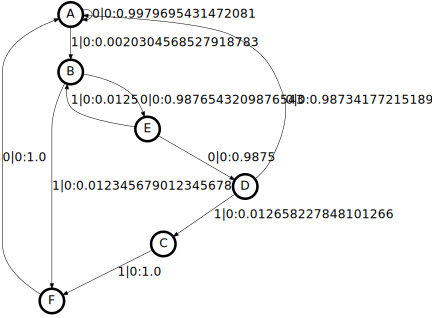

In [28]:
graphviz.Source.from_file('transCSSR_results/'+transducer_fname)

### Setting the Tuning Parameters for <tt>CSSR</tt> Using a Train-Test Split of the Data

Above, we set <tt>L_max_CSSR</tt> arbitrarily. A more principled way to choose <tt>L_max_CSSR</tt> is via a [train/test split](https://en.wikipedia.org/wiki/Training,_test,_and_validation_sets), where we use half of our data to estimate the $\epsilon$-machine, and then use the other half of the data to determine how well the estimated $\epsilon$-machine describes the data. To determine how well the estimated $\epsilon$-machine describes the data, we use the [log-loss](http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss) between the estimated model and the observed testing data. Our goal is to choose the <tt>L_max_CSSR</tt> that **minimizes** the log-loss.

In [7]:
stringY_train = stringY[:len(stringY)//2]
stringY_test  = stringY[len(stringY)//2:]

stringX_train = '0'*len(stringY_train)
stringX_test  = '0'*len(stringY_test)

ays_lookup = {}
y_labels = []

for y_ind, y in enumerate(ays):
    ays_lookup[y] = y_ind
    y_labels.append(y_ind)

arrayY = numpy.zeros(len(stringY_test), dtype = 'int16')

for t, y in enumerate(stringY_test):
    arrayY[t] = ays_lookup[y]

word_lookup_marg, word_lookup_fut = estimate_predictive_distributions(stringX_train, stringY_train, L_max_words)

log_loss_by_L = []

Ls = range(1, L_max_CSSR+1)

for L in Ls:
    epsilon, invepsilon, morph_by_state = run_transCSSR(word_lookup_marg, word_lookup_fut, L, axs, ays, e_symbols, Xt_name, Yt_name, alpha = alpha, all_digits = True)
    
    try: # If we attempt to filter a forbidden past, filter_and_pred_probs will throw an error.
        pred_probs_by_time, cur_states_by_time = filter_and_pred_probs(stringX_test, stringY_test, machine_fname, transducer_fname, axs, ays, inf_alg)
        log_loss_by_L.append(log_loss(y_pred=pred_probs_by_time, y_true=arrayY, labels = y_labels))
    except:
        log_loss_by_L.append(numpy.nan)
    
    print('Using L = {}, the Log-Loss is {}.'.format(L, log_loss_by_L[-1]))

L_opt = Ls[numpy.nanargmin(log_loss_by_L)]

print('Train / Test split with log-loss chooses L_opt = {}'.format(L_opt))

Using L = 1, the Log-Loss is 0.0848753318451947.
Using L = 2, the Log-Loss is 0.08578671361369439.
Using L = 3, the Log-Loss is 0.08578671361369439.
Using L = 4, the Log-Loss is 0.08578671361369439.
Using L = 5, the Log-Loss is 0.08578671361369439.
Train / Test split with log-loss chooses L_opt = 1


In [8]:
pred_probs_by_time.shape

(19981, 2)

Text(0, 0.5, 'Log-Loss(L)')

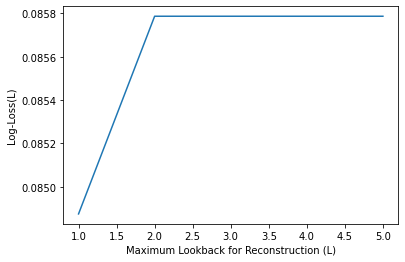

In [9]:
plt.figure()
plt.plot(Ls, log_loss_by_L)
plt.xlabel('Maximum Lookback for Reconstruction (L)')
plt.ylabel('Log-Loss(L)')

Now we re-estimate the $\epsilon$-machine using all of the data, with the <tt>L_max_CSSR</tt> chosen by the log-loss minimization.

In [10]:
word_lookup_marg, word_lookup_fut = estimate_predictive_distributions(stringX, stringY, L_opt)

epsilon, invepsilon, morph_by_state = run_transCSSR(word_lookup_marg, word_lookup_fut, L_opt, axs, ays, e_symbols, Xt_name, Yt_name, alpha = alpha, all_digits = True)

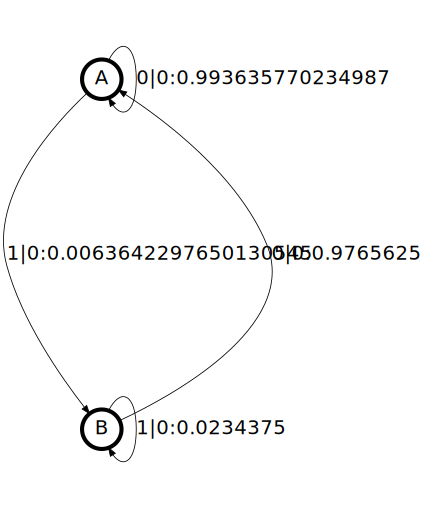

In [11]:
graphviz.Source.from_file(transducer_fname)

### Computing Information- and Computation-theoretic Quantities from the $\epsilon$-Machine

Finally, we investigate some of the information- and computation-theoretic properties of the $\epsilon$-machine. The algorithms for doing so can be found in:

J. P. Crutchfield, C. J. Ellison, and P. M. Riechers, “Exact complexity: The spectral decomposition of intrinsic computation,” Physics Letters A, vol. 380, no. 9, pp. 998–1002, Mar. 2016. [arXiv](https://arxiv.org/abs/1309.3792)

In particular, we compute various asymptotic properties:

* The statistical complexity $C_{\mu}$.
* The entropy rate $h_{\mu}$.
* The excess entropy $\mathbf{E}$.

and various finite-$L$ properties:

* The entropy of words of length $L$: $H[X_{1}^{L}]$
* The conditional entropy using words of length $L-1$: $H[X_{L} \mid X_{1}^{L-1}$]
* The excess entropy between finite past-future blocks: $E(L) = I[X_{-L}^{-1} \wedge X_{0}^{L-1}]$.

In [13]:
L_max_ict = 20

HLs, hLs, hmu, ELs, E, Cmu, etas_matrix = compute_ict_measures(transducer_fname, ays, inf_alg, L_max = L_max_ict)

In [14]:
print('Cmu      = {}\nH[X_{{0}}] = {}\nhmu      = {}\nE        = {}'.format(Cmu, HLs[0], hmu, E))

Cmu      = 0.9167299433492118
H[X_{0}] = 0.9213803753262972
hmu      = 0.6682010884130289
E        = 0.916729943349218


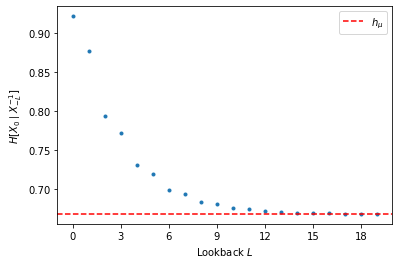

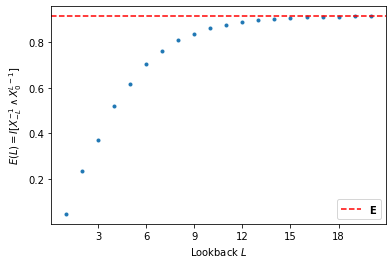

In [15]:
from matplotlib.ticker import MaxNLocator

fig = plt.figure()
plt.plot(range(0, L_max_ict), hLs, '.')
plt.axhline(hmu, color = 'red', linestyle = '--', label = '$h_{\mu}$')
plt.xlabel('Lookback $L$')
plt.ylabel('$H[X_{0} \mid X_{-L}^{-1}]$')
ax = fig.gca(); ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()

fig = plt.figure()
plt.plot(range(1, L_max_ict + 1), ELs, '.')
plt.axhline(E, color = 'red', linestyle = '--', label = '$\mathbf{E}$')
plt.xlabel('Lookback $L$')
plt.ylabel('$E(L) = I[X_{-L}^{-1} \wedge X_{0}^{L-1}]$')
ax = fig.gca(); ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()